In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from keras_ssd300 import ssd_300
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.


In [65]:
class_ids = [33,34,35,36,37,38]
model_name = '/Users/mla/Downloads/rail.h5'

In [ ]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 300 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 7 # Number of classes including the background class, e.g. 21 for the Pascal VOC datasets
scales = [0.1]*7 # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets, the factors for the MS COCO dataset are smaller, namely [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0]]*6
#     [0.5, 1.0, 2.0],
#                  [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
#                  [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
#                  [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
#                  [0.5, 1.0, 2.0],
#                  [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'minmax' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `predictor_sizes` is needed below to set up `SSDBoxEncoder`
model, predictor_sizes = ssd_300(image_size=(img_height, img_width, img_channels),
                                  n_classes=n_classes,
                                  min_scale=None, # You could pass a min scale and max scale instead of the `scales` list, but we're not doing that here
                                  max_scale=None,
                                  scales=scales,
                                  aspect_ratios_global=None,
                                  aspect_ratios_per_layer=aspect_ratios,
                                  two_boxes_for_ar1=two_boxes_for_ar1,
                                  limit_boxes=limit_boxes,
                                  variances=variances,
                                  coords=coords,
                                  normalize_coords=normalize_coords)
model.load_weights(model_name, by_name=True) # You should load pre-trained weights for the modified VGG-16 base network here

In [ ]:
### Set up training

batch_size = 4
val_dir =   '/osn/SpaceNet-MOD/training/vehicles/rgb-ps-dra/DetectNet/300/images/'
images_dir = '/osn/SpaceNet-MOD/training/single-class/18/rgb-ps-dra/DetectNet/300/images/'

val_dir = ''
images_dir = ''

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

# ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=0.1)

# model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes,
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.4,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 5: Create the training set batch generator

classes = ['background', 'car']

train_dataset = BatchGenerator(images_path=images_dir,
                               include_classes=class_ids,
                               box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

train_dataset.parse_csv(labels_path='/osn/share/rail.csv',
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])
#                         image_set_path='./Datasets/VOCdevkit/VOC2012/ImageSets/Main/',
#                         image_set='train.txt',
#                         classes=classes,
#                         exclude_truncated=False,
#                         exclude_difficult=False,
#                         ret=False)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
#                                          brightness=(0.5, 2, 0.5),
#                                          flip=0.5,
#                                          translate=((0, 30), (0, 30), 0.5),
                                         scale=(0.75, 1.2, 0.5),
#                                          random_crop=(300, 300, 1, 3), # This one is important because the Pascal VOC images vary in size
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True, # While the anchor boxes are not being clipped, 
                                                             #the ground truth boxes should be
                                         include_thresh=0.4,
                                         diagnostics=False)

n_train_samples = train_dataset.get_n_samples() # Get the number of samples in the training dataset to compute the epoch length below

# 6: Create the validation set batch generator

val_dataset = BatchGenerator(images_path=val_dir,
                             include_classes=class_ids,
                             box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

val_dataset.parse_csv(labels_path='/osn/share/rail.csv',
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])


val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     random_crop=(300, 300, 1, 3),
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4,
                                     diagnostics=False)

n_val_samples = val_dataset.get_n_samples()


predict_generator = val_dataset.generate(batch_size=1,
                                         train=False,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         random_crop=(300, 300, 1, 3),
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

In [ ]:
# 2: Generate samples

X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

In [62]:
# 3: Make a prediction

y_pred = model.predict(X)

# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.15,
                          iou_threshold=0.45,
                          top_k=20,
                          input_coords='minmax',
                          normalize_coords=normalize_coords,
                          img_height=img_height,
                          img_width=img_width)

print("Predicted boxes:\n")
print(y_pred_decoded[i])

Finally, let's draw the predicted boxes onto the image in blue to visualize the result. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

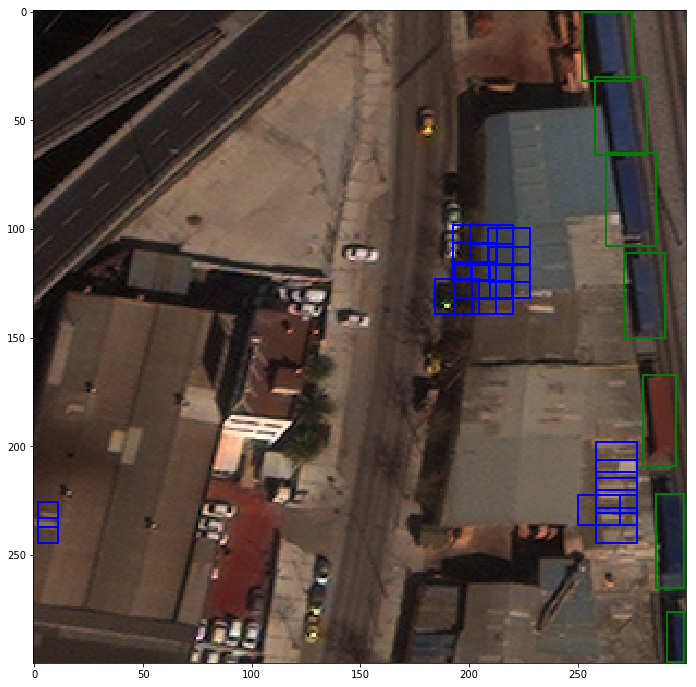

In [64]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

for box in y_pred_decoded[i]:
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
#     current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

for box in y_true[i]:
#     label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
#     current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Testing/Validation 

In [95]:
val_dir = '/osn/SpaceNet-MOD/testing/rgb-ps-dra/300/'

In [93]:
import os
import rasterio
import pandas

In [206]:
results = []
fs = []
new_list = []
for n, p in results:
    if len(p)>0:
        for row in p[0]:
            new_list.append([n]+ row.tolist())
    

for r, d, filenames in os.walk(val_dir):
    for filename in filenames:
        if filename.endswith('png'):
            with rasterio.open(os.path.join(r, filename)) as f:
                fs.append(filename)
                x = f.read().transpose([1,2,0])[np.newaxis,:]
                p = model.predict(x)
                try:
                    d_p = decode_y(p,
                              confidence_thresh=0.15,
                              iou_threshold=0.35,
                              top_k=200,
                              input_coords='minmax',
                              normalize_coords=normalize_coords,
                              img_height=img_height,
                              img_width=img_width)
                    for row in d_p[0]:
                        results.append([filename]+ row.tolist())
                except ValueError as e:
                    pass
pandas.DataFrame(results, columns=['file_name', 'class_id', 'conf', 'xmin', 'xmax', 'ymin', 'ymax']).to_csv('ssd_results.csv')


/home/mla/.local/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()
